# Intuit Quickbooks Upgrade

* Team-lead GitLab userid:
* Group name:
* Team member names:

## Setup

Please complete this python notebook with your group by answering the questions in `intuit.pdf`. Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML file from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the first group assignment for MGTA 455 and you will be using Git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's change to accept so the team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `question1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - question1.ipynb, question2.ipynb, question3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/git-group-workflow-wbg.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/zJHwodmjatY
* Dealing with Merge Conflicts: https://youtu.be/qFnyb8_rgTI
* Group assignment practice: https://youtu.be/4Ty_94gIWeA

In [229]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import os
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from pyrsm import profit_max, confusion, profit_plot, gains_plot
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
mpl.rcParams["figure.dpi"] = 150

In [3]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("../data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [4]:
# show dataset description
rsm.describe(intuit75k)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.rds` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software. 

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip: 5-

In [5]:
# run python code from another notebook
%run ./question1.ipynb

      index     OR       OR%   2.5%  97.5%
1   numords  1.352   35.224%  1.313  1.392
2  version1  2.113  111.278%  1.911  2.335
3  upgraded  2.628  162.846%  2.388  2.894


In [6]:
# importing functions from a module/package
os.chdir("../")

from utils import functions
functions.example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



In [7]:
os.chdir("sub-notebooks")

In [8]:
## Question answers

intuit75k.describe()

,id,zip_bins,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,res1_yes
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000
mean,37500.500000,10.498333,0.245080,2.076280,93.087133,15.838427,15.657173,0.21400,0.028693,0.208387,0.700000,0.048013
std,21650.779432,5.765751,0.430137,1.241355,81.205900,9.539057,10.026312,0.41013,0.166944,0.406157,0.458261,0.213796
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,18750.750000,5.000000,0.000000,1.000000,37.000000,8.000000,7.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,37500.500000,10.000000,0.000000,2.000000,71.000000,15.000000,14.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,56250.250000,15.000000,0.000000,3.000000,124.500000,24.000000,24.000000,0.00000,0.000000,0.000000,1.000000,0.000000
max,75000.000000,20.000000,1.000000,5.000000,1149.000000,36.000000,36.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [9]:
scaler = preprocessing.StandardScaler()
sf = scaler.fit(intuit75k.query('training==1')[['numords','dollars','last','sincepurch']])
intuit75k[['numords','dollars','last','sincepurch']] = sf.transform(intuit75k[['numords','dollars','last','sincepurch']])

In [10]:
intuit75k = intuit75k.join(pd.get_dummies(intuit75k.sex), how='inner')
intuit75k = intuit75k.join(pd.get_dummies(intuit75k.zip_bins), how='inner')

In [11]:
intuit_train = intuit75k.query('training == 1').reset_index()
intuit_val = intuit75k.query('training == 0').reset_index()

In [12]:
intuit_train.dtypes

index            int64
id               int32
zip             object
zip_bins         int32
sex           category
bizflag          int32
numords        float64
dollars        float64
last           float64
sincepurch     float64
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
Female           uint8
Male             uint8
Unknown          uint8
1                uint8
2                uint8
3                uint8
4                uint8
5                uint8
6                uint8
7                uint8
8                uint8
9                uint8
10               uint8
11               uint8
12               uint8
13               uint8
14               uint8
15               uint8
16               uint8
17               uint8
18               uint8
19               uint8
20               uint8
dtype: object

In [13]:
X_train = intuit_train.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index'])
y_train = intuit_train[['res1_yes']]
X_test = intuit_val.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index'])
y_test = intuit_val[['res1_yes']]

In [213]:
## Likely overfitted model

clf = MLPClassifier(random_state=1234, activation='tanh', solver='adam', max_iter=3000, hidden_layer_sizes = (100,100,100)).fit(X_train, y_train.values.ravel())

In [214]:
pred = clf.predict_proba(X_test)
pred_train = clf.predict_proba(X_train)
    
probs = pd.Series([p[1] for p in pred])
probs_train = pd.Series([p[1] for p in pred_train])

In [215]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.res1_yes, pred[:,1])
print(f'Test data auc is {metrics.auc(fpr,tpr)}')

Test data auc is 0.630800909169065


In [216]:
fpr, tpr, thresholds = metrics.roc_curve(y_train.res1_yes, pred_train[:,1])
print(f'Train data auc is {metrics.auc(fpr,tpr)}')

Train data auc is 0.9998729194146887


In [217]:
breakeven = 1.41/60

In [262]:
# Profit calculation

# Prediction on test data

X = intuit_val.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index'])
y = intuit_val[['res1_yes']]
pred_prof = pd.Series(clf.predict_proba(X)[:,1]/2) 
pred_prof.name = 'predictions_1'

df1 = X.join(y,how='inner').join(pred_prof, how='inner')

In [263]:
df1

,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,Female,Male,...,13,14,15,16,17,18,19,20,res1_yes,predictions_1
0,0,-0.863720,-0.286561,-1.241930,-1.258669,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.425448e-09
1,0,1.556202,0.003936,-0.194459,1.335150,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1.711308e-01
2,0,-0.863720,-0.842831,-1.451425,-1.258669,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.782717e-04
3,0,-0.863720,-0.533792,-0.299206,2.033485,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.315917e-06
4,0,-0.863720,-0.595600,-0.089711,-1.158907,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.531257e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,1,-0.863720,0.455133,-0.403953,0.038240,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1.313041e-12
22496,0,-0.057079,-0.873735,0.957760,-1.458194,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.586243e-13
22497,0,1.556202,0.022478,-0.927689,0.736576,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1.294792e-06
22498,0,2.362843,0.961957,-0.718194,0.437289,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,2.705618e-05


In [264]:
p = profit_max(df1,'res1_yes',1,'predictions_1',1.41,60)

print(f'The profit for {clf} on the test data is ${p}')

The profit for MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100, 100),
              max_iter=3000, random_state=1234) on the test data is $9532.5


In [265]:
# Confusion Matrix

TP, FP, TN, FN, contact = confusion(df1,'res1_yes',1,'predictions_1',1.41,60)

print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')

TP: 200
TN: 19847
FP: 1550
FN: 903


In [266]:
a = ((probs/2) > breakeven).astype(int)
a_train = ((probs_train/2) > breakeven).astype(int)

In [267]:
acc = np.mean(a == y_test['res1_yes'])
print(f'Test data accuracy {acc}')

Test data accuracy 0.8909777777777778


In [268]:
acc_train = np.mean(a_train == y_train['res1_yes'])
print(f'Train data accuracy {acc_train}')

Train data accuracy 0.989352380952381


In [269]:
print(f'Minimum Loss is {min(clf.loss_curve_)}')

Minimum Loss is 0.010325765043631535


In [270]:
l = clf.loss_curve_
x = list(range(clf.n_iter_))

In [271]:
df = pd.DataFrame({'Loss':l,'Epoch':x})

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

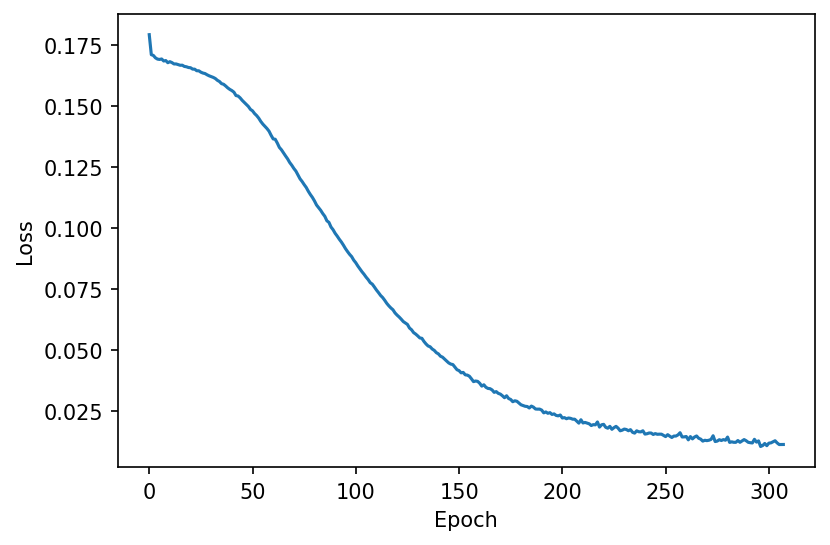

In [272]:
sns.lineplot(x = "Epoch",y = "Loss", data = df)

In [128]:
#Cross validation

mlp = MLPClassifier(random_state=1234,max_iter=1000)

In [129]:
parameter_space = {
    'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (1,1), (2,2), (3,3), (4,4), (5,5), (6,6), (7,7), (1,1,1), (2,2,2), (3,3,3), (4,4,4), (5,5,5), (6,6,6), (7,7,7)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'learning_rate': ['adaptive','constant'],
}

In [136]:
clf_3 = GridSearchCV(mlp, parameter_space, n_jobs=-1, scoring='roc_auc', verbose=4)
clf_3.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(estimator=MLPClassifier(max_iter=1000, random_state=1234),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (1, 1), (2, 2),
                                                (3, 3), (4, 4), (5, 5), (6, 6),
                                                (7, 7)],
                         'learning_rate': ['adaptive', 'constant'],
                         'solver': ['sgd', 'adam', 'lbfgs']},
             scoring='roc_auc', verbose=4)

In [137]:
clf_3.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (3, 3),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [138]:
# Training model using the parameters selected by CV above

clf_2 = MLPClassifier(random_state=1234, activation='relu', solver='adam', max_iter=1000, hidden_layer_sizes = (3,3), learning_rate='adaptive').fit(X_train, y_train.values.ravel())

In [139]:
pred = clf_2.predict_proba(X_test)
pred_train = clf_2.predict_proba(X_train)
    
probs = pd.Series([p[1] for p in pred])
probs_train = pd.Series([p[1] for p in pred_train])

In [153]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.res1_yes, pred[:,1])
print(f'Test data auc is {metrics.auc(fpr,tpr)}')

Test data auc is 0.7531997626699771


In [154]:
fpr, tpr, thresholds = metrics.roc_curve(y_train.res1_yes, pred_train[:,1])
print(f'Train data auc is {metrics.auc(fpr,tpr)}')

Train data auc is 0.7642327653571199


In [169]:
breakeven = 1.41/60

In [273]:
# Profit calculation

# Prediction on test data

X = intuit_val.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index'])
y = intuit_val[['res1_yes']]
pred_prof = pd.Series(clf_2.predict_proba(X)[:,1]/2)
pred_prof.name = 'predictions_2'

df2 = X.join(y,how='inner').join(pred_prof, how='inner')

In [274]:
df2

,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,Female,Male,...,13,14,15,16,17,18,19,20,res1_yes,predictions_2
0,0,-0.863720,-0.286561,-1.241930,-1.258669,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.012283
1,0,1.556202,0.003936,-0.194459,1.335150,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0.036346
2,0,-0.863720,-0.842831,-1.451425,-1.258669,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.013517
3,0,-0.863720,-0.533792,-0.299206,2.033485,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.011064
4,0,-0.863720,-0.595600,-0.089711,-1.158907,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.008339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,1,-0.863720,0.455133,-0.403953,0.038240,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0.010486
22496,0,-0.057079,-0.873735,0.957760,-1.458194,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.008102
22497,0,1.556202,0.022478,-0.927689,0.736576,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0.065620
22498,0,2.362843,0.961957,-0.718194,0.437289,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0.053914


In [275]:
p = profit_max(df2,'res1_yes',1,'predictions_2',1.41,60)

print(f'The profit for {clf_2} on the test data is ${p}')

The profit for MLPClassifier(hidden_layer_sizes=(3, 3), learning_rate='adaptive',
              max_iter=1000, random_state=1234) on the test data is $33575.4


In [276]:
# Confusion Matrix

TP, FP, TN, FN, contact = confusion(df2,'res1_yes',1,'predictions_2',1.41,60)

print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')

TP: 702
TN: 16039
FP: 5358
FN: 401


In [277]:
a = ((probs/2) > breakeven).astype(int)
a_train = ((probs_train/2) > breakeven).astype(int)

In [278]:
acc = np.mean(a == y_test['res1_yes'])
print(f'Test data accuracy {acc}')

Test data accuracy 0.8909777777777778


In [279]:
acc_train = np.mean(a_train == y_train['res1_yes'])
print(f'Train data accuracy {acc_train}')

Train data accuracy 0.989352380952381


In [280]:
print(f'Minimum Loss is {min(clf_2.loss_curve_)}')

Minimum Loss is 0.1677264363660148


In [281]:
l = clf_2.loss_curve_
x = list(range(clf_2.n_iter_))

In [282]:
df = pd.DataFrame({'Loss':l,'Epoch':x})

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

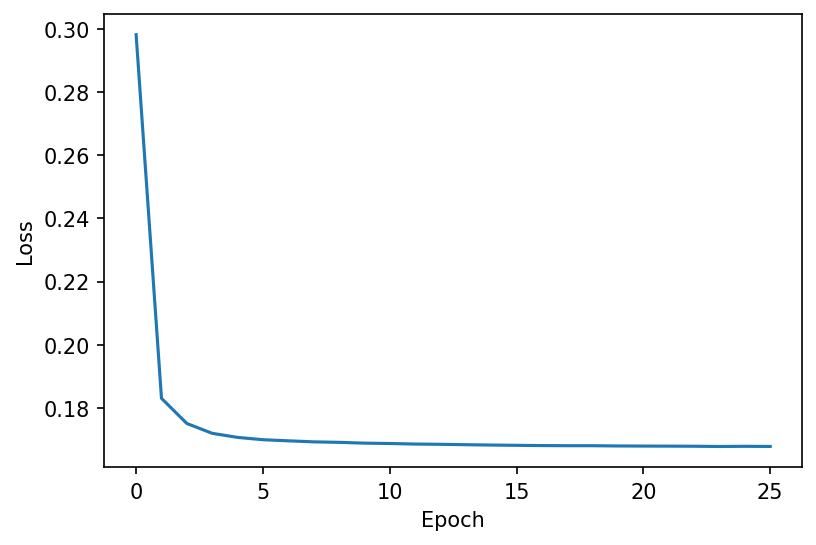

In [283]:
sns.lineplot(x = "Epoch",y = "Loss", data = df)

In [284]:
# Profit Plot

df = df1.join(df2.predictions_2, how='inner')

<AxesSubplot:xlabel='Proportion of customers', ylabel='Profit'>

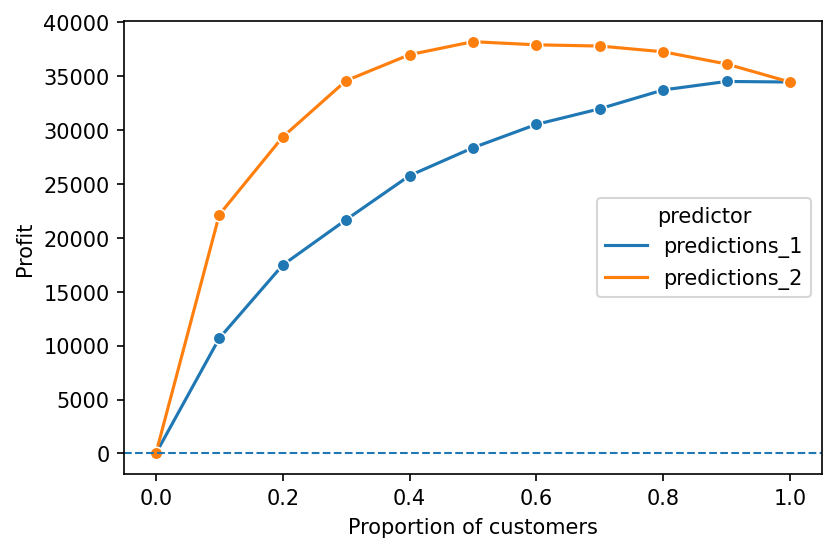

In [285]:
profit_plot(df=df,rvar='res1_yes',lev=1,pred=['predictions_1','predictions_2'],cost=1.41,margin=60)

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

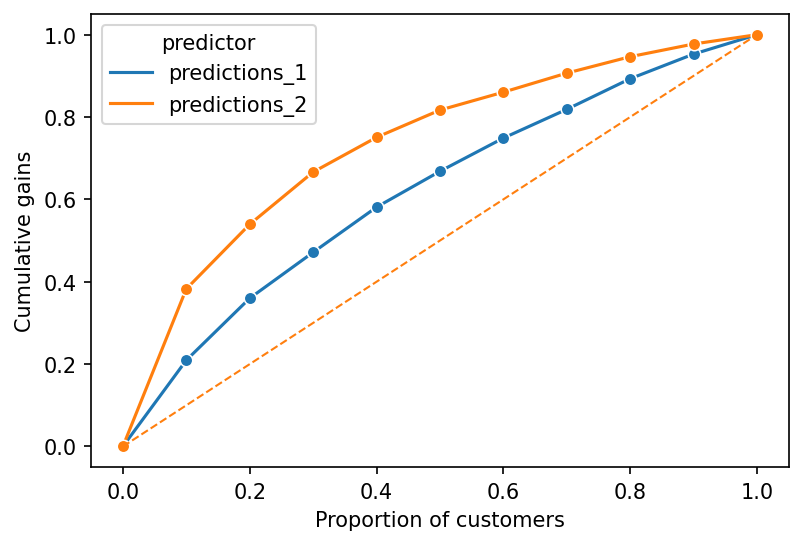

In [287]:
# Gains chart

gains_plot(df=df,rvar='res1_yes',lev=1,pred=['predictions_1','predictions_2'])